In [13]:
import requests,os,subprocess,shutil
from astropy.io import fits
from astropy.wcs import WCS
from astropy.io import ascii
from photutils.segmentation import detect_sources
from photutils.background import Background2D, MedianBackground
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "sans-serif"
from astropy.visualization import ZScaleInterval
from astropy.visualization.mpl_normalize import ImageNormalize

from photutils.segmentation import SourceCatalog
from photutils.segmentation import deblend_sources
from astropy.convolution import convolve

from astropy.convolution import Gaussian2DKernel, convolve
from astropy.stats import gaussian_fwhm_to_sigma

In [21]:
def getData(path,output,test=False):
  server = "t5@phenex.hpr.phys.titech.ac.jp"
  File = server + ":" + path
  cmd = "scp {} {}".format(File,output)
  if test == False:
    print(cmd)
  else:
    subprocess.run(cmd,shell=True,stdout=subprocess.PIPE, stderr=subprocess.PIPE, encoding="utf_8")
  if os.path.exists(output):
    return output
  else:
    return False

SE = "/opt/local/bin/sex"
config = "/Users/sasada/work/sextractor/mitsume.sex"
def do_sextractor(fitsfile,thr):
  cmd = "{} -c {} {} -DETECT_THRESH {} -DETECT_MINAREA 10".format(SE,config,fitsfile,thr)
  proc = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, encoding="utf_8")
  if os.path.exists("test.cat"):
    tab = ascii.read("test.cat")
    os.remove("test.cat")
    return tab
  else:
    print("Cannot do sextractor.")
    return

def TestASingleFits( path, thr=1.5 ):
  tmp = "temp.fits"
  if os.path.exists(tmp): os.remove(tmp)
  if os.path.basename(path):
    cmd = "cp {} {}".format(os.path.basename(path),tmp)
    os.system(cmd)
    fh = fits.open(tmp)
  else:
    fcp = getData(path,tmp)
    if fcp == False:
      print("No data is downloaded")
      return
    else:
      fh = fits.open(fcp)
      shutil.copy(fcp,tmp)
  """
  response = requests.get(
    url = url,
    auth=HTTPDigestAuth('jgem', 'asakura')
    )
  fh = fits.HDUList.fromstring(response.content)
  """
  image=fh[0].data

  bkg_estimator = MedianBackground()
  bkg = Background2D(image, (50, 50), filter_size=(3, 3),
                      bkg_estimator=bkg_estimator)

  thresh = thr * bkg.background_rms
  data = image-bkg.background

  segment_map = detect_sources(data, thresh, npixels=5)

  sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
  kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
  convolved_data = convolve(data, kernel, normalize_kernel=True)

  segm_deblend = deblend_sources(convolved_data, segment_map,
                                  npixels=10, nlevels=32, contrast=0.001)

  cat = SourceCatalog(data, segm_deblend )#, convolved_data=convolved_data)

  tab = do_sextractor(tmp,thr)

  #max_value
  fig, axs = plt.subplots(3,2,figsize=(8,12),dpi=150)
  title = "{}, ".format(os.path.basename(path))
  title = title + ", ".join( [ fh[0].header[akey] if akey in fh[0].header else "" for akey in [
      "OBJECT",
      "DATE-OBS"
      ] ] )  
  fig.suptitle( title )

  for ax, xkey in zip(axs.flatten(),["kron_flux","max_value"]):
    x = cat.to_table()[xkey]
    for ykey in ["semimajor_sigma","semiminor_sigma"]:
      y = cat.to_table()[ykey]
      y.name = ykey
      ax.scatter(x,y,0.9,label=ykey)
      ax.set_xlabel(x.name)
      ax.set_ylabel("size")
      ax.legend()
      ax.semilogx()

  axs[1][0].scatter(tab["FLUX_AUTO"],tab["FWHM_IMAGE"],0.9)
  axs[1][0].set_xlabel("FLUX_AUTO")
  axs[1][0].set_ylabel("FWHM_IMAGE")
  axs[1][0].semilogx()
  axs[1][1].scatter(tab["FLUX_MAX"],tab["FWHM_IMAGE"],0.9)
  axs[1][1].set_xlabel("FLUX_MAX")
  axs[1][1].set_ylabel("FWHM_IMAGE")
  axs[1][1].semilogx()

  vmin, vmax = ZScaleInterval().get_limits(data)
  axs.flatten()[4].imshow(data,  vmin=vmin, vmax=vmax )
  #plt.tight_layout()
  plt.show()
  return fh, cat


100%|██████████| 240/240 [00:00<00:00, 348.82it/s]


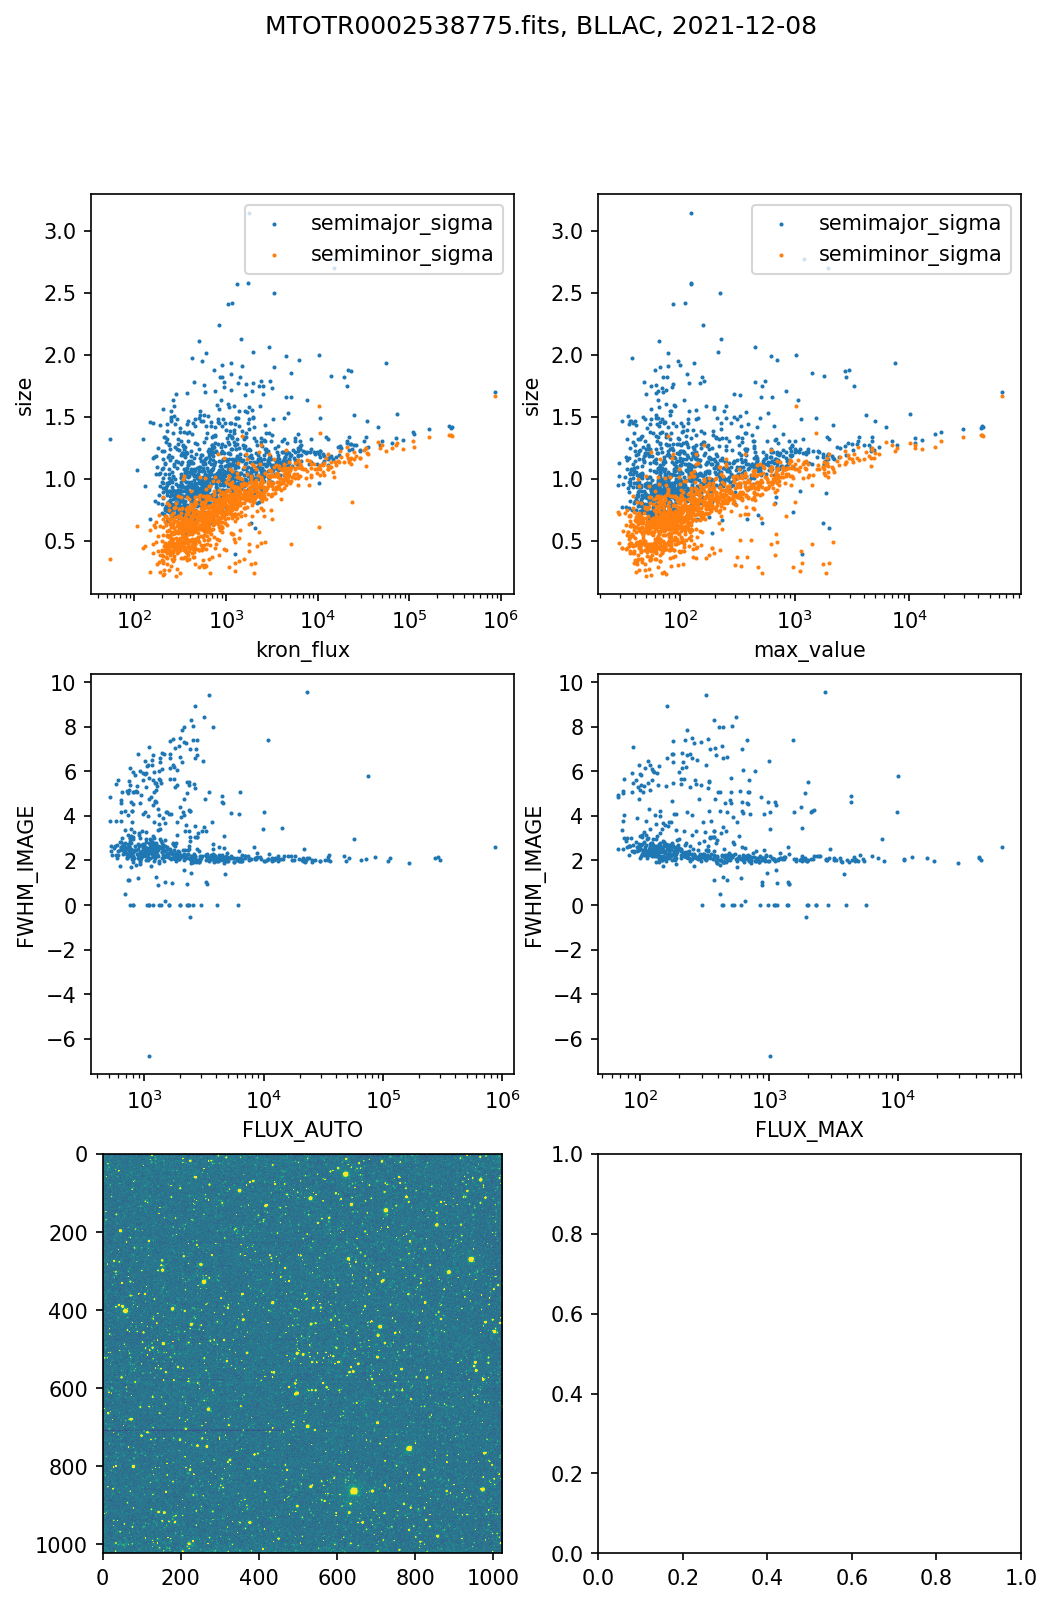

([<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f88a0c7bf70>],
 <photutils.segmentation.catalog.SourceCatalog>
 Length: 1122
 labels: [   1    2    3    4    5 ... 1118 1119 1120 1121 1122])

In [22]:
path = "MTOTR0002538775.fits"
TestASingleFits( path, thr=2.0 )

100%|██████████| 150/150 [00:00<00:00, 288.27it/s]


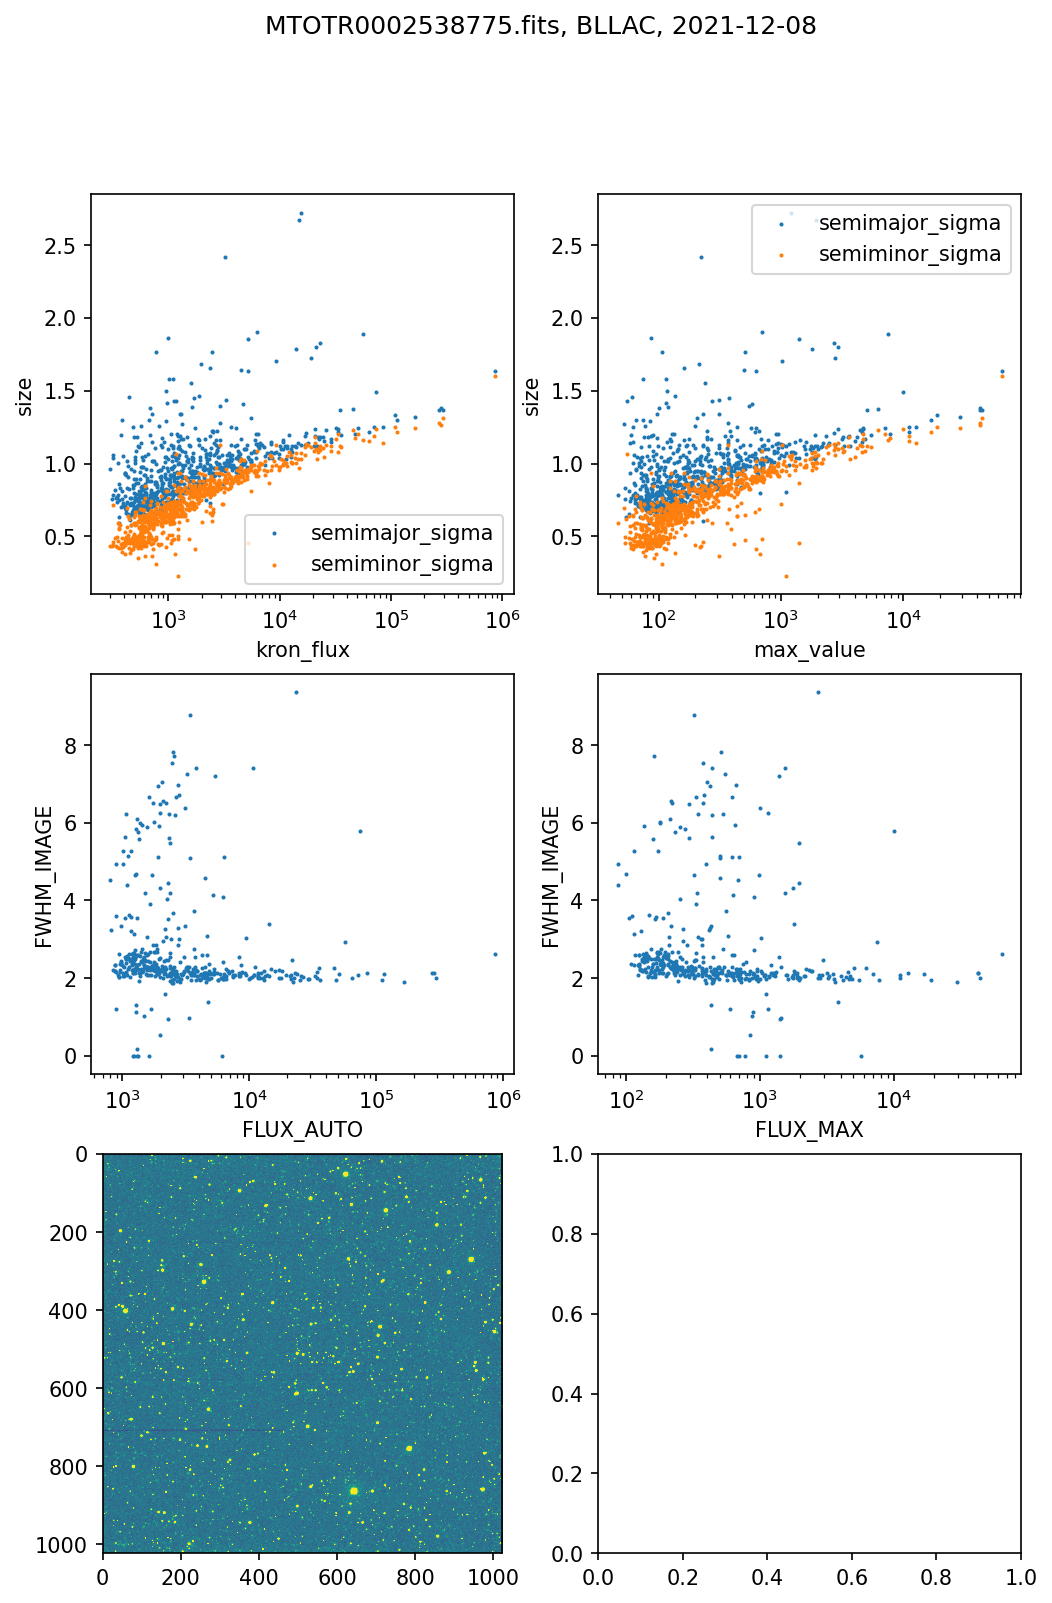

([<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f8898410880>],
 <photutils.segmentation.catalog.SourceCatalog>
 Length: 719
 labels: [  1   2   3   4   5 ... 715 716 717 718 719])

In [23]:
TestASingleFits( path, thr=3.0 )

100%|██████████| 108/108 [00:00<00:00, 376.34it/s]


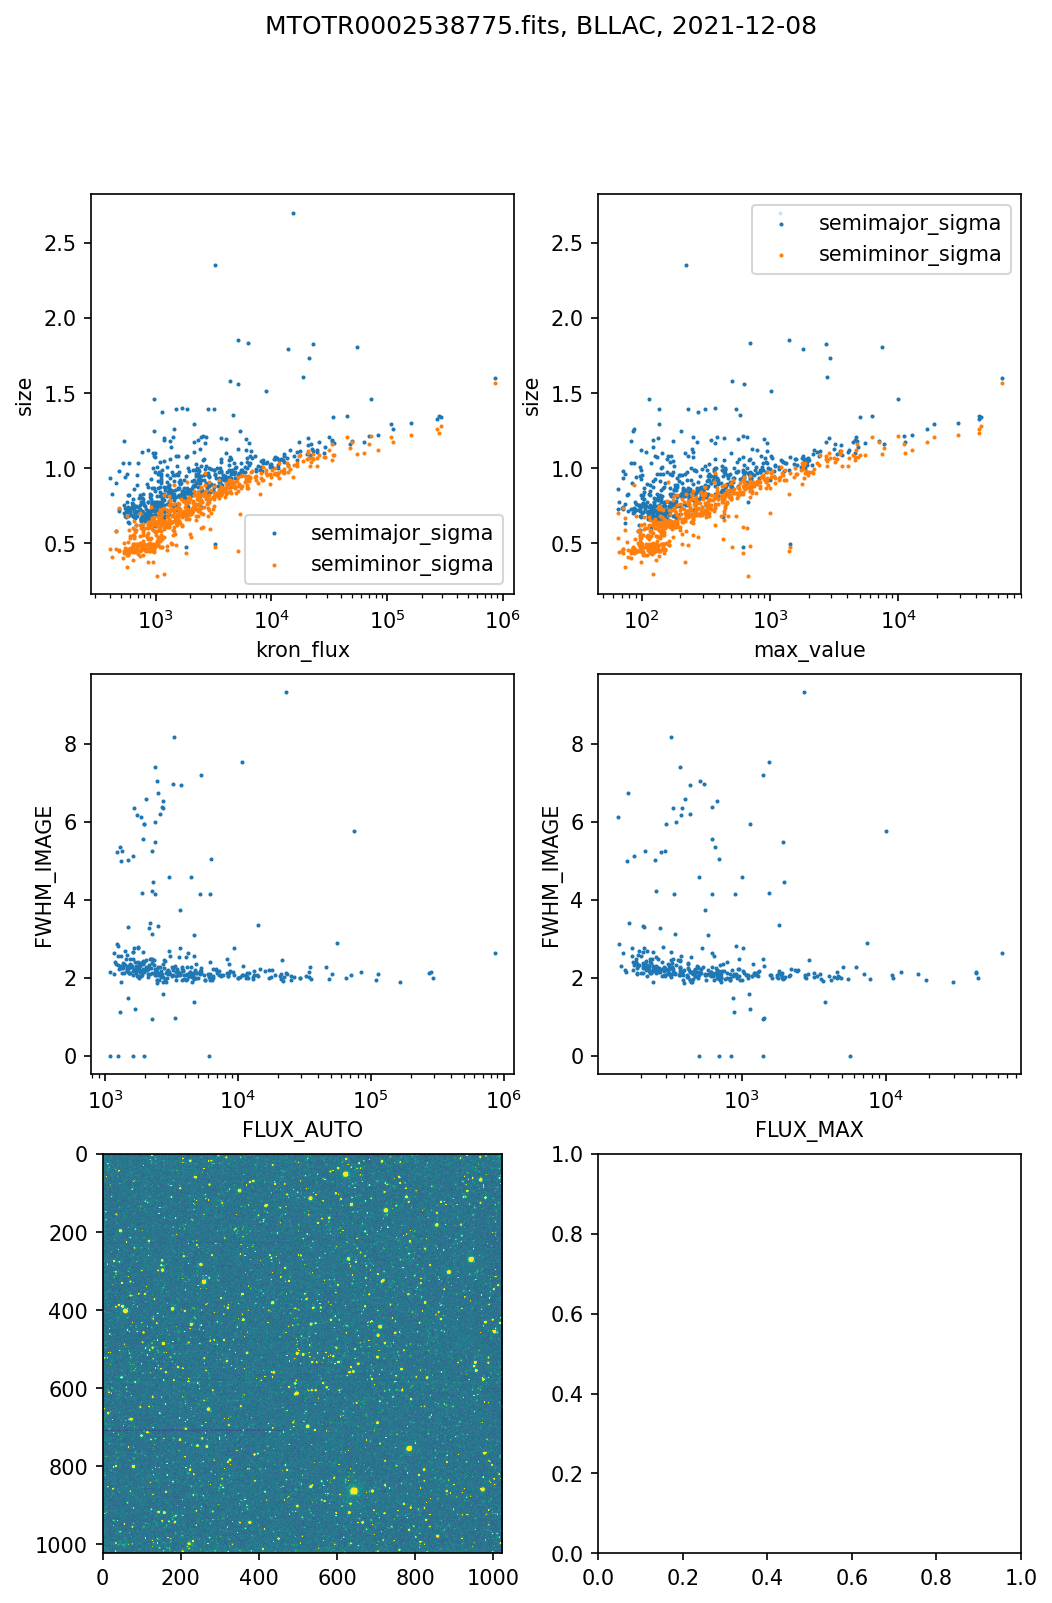

([<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f88875d9c40>],
 <photutils.segmentation.catalog.SourceCatalog>
 Length: 556
 labels: [  1   2   3   4   5 ... 552 553 554 555 556])

In [24]:
TestASingleFits( path, thr=4.0 )

100%|██████████| 87/87 [00:00<00:00, 389.07it/s]


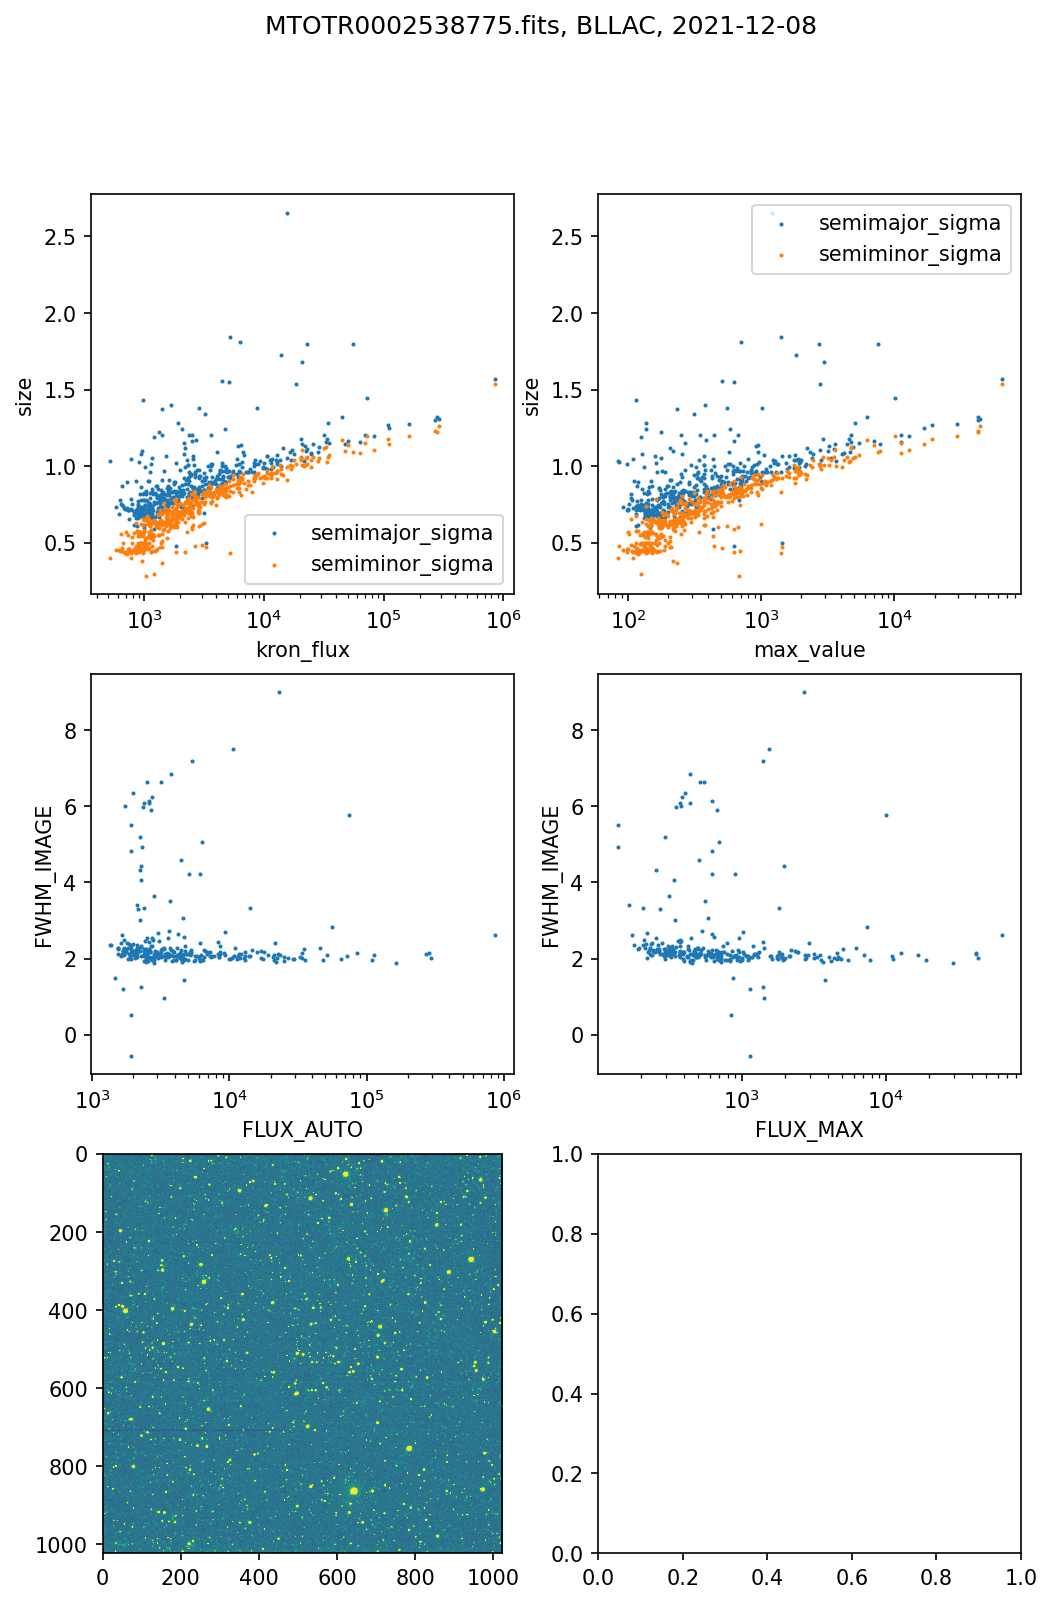

([<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f8886231430>],
 <photutils.segmentation.catalog.SourceCatalog>
 Length: 459
 labels: [  1   2   3   4   5 ... 455 456 457 458 459])

In [25]:
TestASingleFits( path, thr=5.0 )